# Discrepancy study: usecase on halfmoons dataset

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx

import sys; sys.path.insert(0, '..') # add parent folder path where discrepancies folder is

from discrepancies import datasets, pool, pool2graph, evaluation, discrepancies_intervals

RANDOM_STATE = 42

import matplotlib.pyplot as plt
%matplotlib inline

# Preparation

### Load the data, train a pool of classifiers

* The dataset is Adult, containing both continuous and categorical variables
* We build a pool of classifiers and evaluate their performance

In [4]:
# Get data and fit a pool of classifiers on it
X_train, X_test, y_train, y_test, scaler, feature_names, target_names, cat_names = datasets.get_dataset(dataset='half-moons', n_samples=30, noise=0.1, test_size=0.1)
print(X_train.shape, y_train.mean())

pool1 = pool.BasicPool(["LR", "SVMrbf"]) # TODO: other pool, better one
pool1 = pool1.fit(X_train, y_train)

preds = pool1.predict(X_train)
from sklearn.metrics import f1_score
print({c: f1_score(y_train, preds[c]) for c in preds.columns})


(27, 2) 0.48148148148148145
{'SVMrbf': 0.9230769230769231, 'LR': 0.8461538461538461}


In [5]:
pool1.models

{'SVMrbf': SVC(probability=True), 'LR': LogisticRegression()}

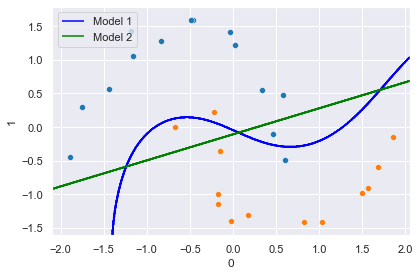

In [6]:
sns.set_context('notebook')
sns.set_style('darkgrid')

def plot_classification_contour(X, clf, ax=[0,1]):
    ## Inspired by scikit-learn documentation
    h = .02  # step size in the mesh
    cm = plt.cm.RdBu
    x_min, x_max = X[:, ax[0]].min() - .5, X[:, ax[0]].max() + .5
    y_min, y_max = X[:, ax[1]].min() - .5, X[:, ax[1]].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    #plt.sca(ax)
    plt.contourf(xx, yy, Z, alpha=.5, cmap=None)
    
def plot_classification_contourDisc(X, pool, ax=[0,1]):
    ## Inspired by scikit-learn documentation
    h = .02  # step size in the mesh
    cm = plt.cm.RdBu
    x_min, x_max = X[:, ax[0]].min() - .5, X[:, ax[0]].max() + .5
    y_min, y_max = X[:, ax[1]].min() - .5, X[:, ax[1]].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = pool.predict_discrepancies(np.c_[xx.ravel(), yy.ravel()])#[:, 1]
    Z = Z.values.reshape(xx.shape)
    #plt.sca(ax)
    plt.contour(xx, yy, Z, alpha=.5, colos=["blue", "red"])
    

margin = 0.2
x_min = X_train.iloc[:,0].min() - margin
x_max = X_train.iloc[:,0].max() + margin
y_min = X_train.iloc[:,1].min() - margin
y_max = X_train.iloc[:,1].max() + margin
x_step = y_step = 0.005

x = np.arange(x_min, x_max, x_step)
y = np.arange(y_min, y_max, y_step)
xx, yy = np.meshgrid(x, y)

X_tmp = np.concatenate((xx.reshape(-1,1),yy.reshape(-1,1)), axis=1)
X_tmp = pd.DataFrame(X_tmp)
X_tmp.columns = ['Feature 1', 'Feature 2']

colors = ['blue',  'green', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

plt.figure(figsize=(6,4))

sns.scatterplot(x=X_train[y_train==0].iloc[:,0], y=X_train[y_train==0].iloc[:,1])
sns.scatterplot(x=X_train[y_train==1].iloc[:,0], y=X_train[y_train==1].iloc[:,1])

plots = []
i = 0
for mn, m in pool1.models.items():
    preds = m.predict(X_tmp)
    preds = preds.reshape((xx.shape[0], yy.shape[1]))
    tmp = plt.contour(xx, yy, preds, colors=colors[i])
    plots.append(tmp)
    i += 1

contours = [p.legend_elements()[0][0] for p in plots]
plt.legend(contours, ["Model 1", "Model 2"], bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
plt.tight_layout()


It looks that several of these classifiers have similar performance. How can we choose among them? 

We measure that classifiers disagree over 17,5% of test instances. What can we learn about these discrepancies ? 

### Build the graph with DIG

* DIG relies on two main parameters: k_init and max_epochs. Essentially, the higher these two are, the better.
* Here we select random values that seem good enough

In [159]:
%%time

# build p2g
# p2g = pool2graph_cat2.pool2graph(X_train, y_train, pool1, k_init=3, categorical_names=cat_names)
p2g = pool2graph.pool2graph(X_train, y_train, pool1, k_init=20)
p2g.fit(max_epochs=4)
print(len(p2g.G.nodes))
print(len(p2g.G.edges))

INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4


1062
1242
CPU times: user 420 ms, sys: 8.23 ms, total: 428 ms
Wall time: 423 ms


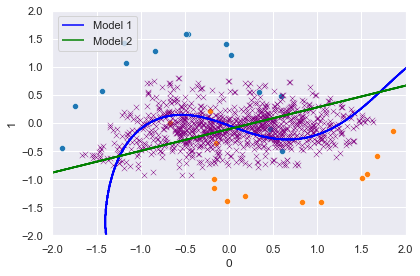

In [160]:
sns.set_context('notebook')
sns.set_style('darkgrid')

margin = 1.0
x_min = X_train.iloc[:,0].min() - margin
x_max = X_train.iloc[:,0].max() + margin
y_min = X_train.iloc[:,1].min() - margin
y_max = X_train.iloc[:,1].max() + margin
x_step = y_step = 0.005

x = np.arange(x_min, x_max, x_step)
y = np.arange(y_min, y_max, y_step)
xx, yy = np.meshgrid(x, y)

X_tmp = np.concatenate((xx.reshape(-1,1),yy.reshape(-1,1)), axis=1)
X_tmp = pd.DataFrame(X_tmp)
X_tmp.columns = ['Feature 1', 'Feature 2']

colors = ['blue',  'green', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

plt.figure(figsize=(6,4))

sns.scatterplot(x=X_train[y_train==0].iloc[:,0], y=X_train[y_train==0].iloc[:,1])
sns.scatterplot(x=X_train[y_train==1].iloc[:,0], y=X_train[y_train==1].iloc[:,1])

plots = []
i = 0
for mn, m in pool1.models.items():
    preds = m.predict(X_tmp)
    preds = preds.reshape((xx.shape[0], yy.shape[1]))
    tmp = plt.contour(xx, yy, preds, colors=colors[i])
    plots.append(tmp)
    i += 1

contours = [p.legend_elements()[0][0] for p in plots]
plt.legend(contours, ["Model 1", "Model 2"], bbox_to_anchor=(0, 1), loc='upper left', ncol=1)


lnodes = p2g.get_nodes()
nodes = p2g.get_nodes_attributes(lnodes)[0]
new_nodes = nodes[nodes.index < 0]
disc = pool1.predict_discrepancies(nodes)

sns.scatterplot(x=new_nodes.iloc[:, 0], y=new_nodes.iloc[:, 1], color='purple', alpha=1.0, s=30, marker="x")


plt.ylim((-2.0, 2.0))
plt.xlim((-2.0, 2.0))

plt.tight_layout()
#plt.savefig("../../results2/halfmoons_DIGsampling.pdf")

-10.989844453467306


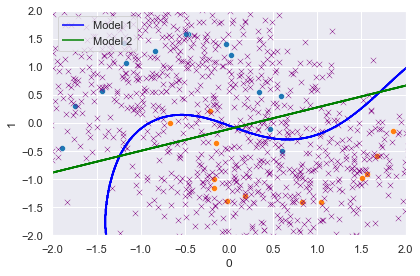

In [161]:
# comparaison avec un KDE
from sklearn.neighbors import KernelDensity

sns.set_context('notebook')
sns.set_style('darkgrid')


x_min = X_train.iloc[:,0].min() - margin
x_max = X_train.iloc[:,0].max() + margin
y_min = X_train.iloc[:,1].min() - margin
y_max = X_train.iloc[:,1].max() + margin
x_step = y_step = 0.005

x = np.arange(x_min, x_max, x_step)
y = np.arange(y_min, y_max, y_step)
xx, yy = np.meshgrid(x, y)

X_tmp = np.concatenate((xx.reshape(-1,1),yy.reshape(-1,1)), axis=1)
X_tmp = pd.DataFrame(X_tmp)
X_tmp.columns = ['Feature 1', 'Feature 2']

colors = ['blue',  'green', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

plt.figure(figsize=(6,4))

sns.scatterplot(x=X_train[y_train==0].iloc[:,0], y=X_train[y_train==0].iloc[:,1])
sns.scatterplot(x=X_train[y_train==1].iloc[:,0], y=X_train[y_train==1].iloc[:,1])

plots = []
i = 0
for mn, m in pool1.models.items():
    preds = m.predict(X_tmp)
    preds = preds.reshape((xx.shape[0], yy.shape[1]))
    tmp = plt.contour(xx, yy, preds, colors=colors[i])
    plots.append(tmp)
    i += 1

contours = [p.legend_elements()[0][0] for p in plots]
plt.legend(contours, ["Model 1", "Model 2"], bbox_to_anchor=(0, 1), loc='upper left', ncol=1)

kde = KernelDensity(bandwidth=0.5).fit(X=X_train.values)
print(kde.score(X_test.values))
kde_nodes = kde.sample(new_nodes.shape[0])
sns.scatterplot(x=kde_nodes[:, 0], y=kde_nodes[:, 1], color='purple', alpha=1.0, s=30,marker="x")

plt.ylim((-2.0, 2.0))
plt.xlim((-2.0, 2.0))
plt.tight_layout()

#plt.savefig("../../results2/halfmoons_KDEsampling.pdf")

# Understanding discrepancies

In [38]:
intervals = discrepancies_intervals.get_discrepancies_intervals(p2g.G)
len(intervals)

KeyboardInterrupt: 

In [ ]:
X = X_train.copy().values
x_min = X[:,0].min()
x_max = X[:,0].max()
y_min = X[:,1].min()
y_max = X[:,1].max()
x_step = y_step = 0.005

x = np.arange(x_min, x_max, x_step)
y = np.arange(y_min, y_max, y_step)
xx, yy = np.meshgrid(x, y)

X_tmp = np.concatenate((xx.reshape(-1,1),yy.reshape(-1,1)), axis=1)
X_tmp = pd.DataFrame(X_tmp)
X_tmp.columns = ['Feature 1', 'Feature 2']

#colors = [(round(a[0], 2), round(a[1], 2), round(a[2], 2), 0) for a in list(sns.color_palette())]#['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

Age is much more subject to disagreement among classifiers than e.g. captial-gain

In [ ]:
sns.set_context('notebook')
sns.set_style('darkgrid')

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_train.iloc[:, 0], y=X_train.iloc[:, 1], hue=y_train)

preds = pool1.predict(X_tmp)
plots = []
i = 0
for p in range(preds.shape[1]):
    #preds = pool1.models.predict(X_tmp, model=p)
    preds_m = preds.values[:, p]
    preds_m = preds_m.reshape((xx.shape[0], yy.shape[1]))
    tmp = plt.contour(xx, yy, preds_m, colors=colors[i])
    plots.append(tmp)
    i += 1


contours = [p.legend_elements()[0][0] for p in plots]
plt.legend(contours, preds.columns, bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
plt.tight_layout()

In [ ]:
global_interval_coord = []
for di in intervals:
    interval_coord = np.array((di.border_features.iloc[0] - di.border_features.iloc[1]).abs())
    global_interval_coord.append(interval_coord)
global_interval_coord = np.array(global_interval_coord)
global_interval_coord = pd.DataFrame(global_interval_coord, columns = X_train.columns)


In [9]:
sns.set_context('notebook')
sns.set_style('darkgrid')

plt.figure(figsize=(8,6))

preds = pool1.predict(X_tmp)


<Figure size 576x432 with 0 Axes>

In [ ]:
plots = []
i = 0
for p in range(preds.shape[1]):
    #preds = pool1.models.predict(X_tmp, model=p)
    preds_m = preds.values[:, p]
    preds_m = preds_m.reshape((xx.shape[0], yy.shape[1]))
    tmp = plt.contour(xx, yy, preds_m, colors=colors[i], alpha=0.1)
    plots.append(tmp)
    i += 1

contours = [p.legend_elements()[0][0] for p in plots]
plt.legend(contours, preds.columns, bbox_to_anchor=(0, 1), loc='upper left', ncol=1)

sns.scatterplot(x=X_train.iloc[:, 0], y=X_train.iloc[:, 1], hue=y_train)


#lnodes = p2g.get_nodes()#discrepancies=True)
#discnodes = p2g.get_nodes_attributes(lnodes)
#sns.scatterplot(discnodes[0].iloc[:, 0], discnodes[0].iloc[:, 1], color='black', alpha=0.2)

di = np.array([di.border_features.values for di in intervals]).reshape(386*2, 2)
#sns.scatterplot(x=di[:,0], y=di[:,1], color="lime", s=100)

for interval in intervals:
    di = interval.border_features
    plt.plot(di.iloc[:, 0], di.iloc[:, 1], marker =None, color='red')


plt.tight_layout()

array([[ 1.06847517, -0.03791628],
       [ 0.8422042 , -0.07338115],
       [ 1.14523738,  0.78854959],
       ...,
       [-1.01024391, -0.18826775],
       [ 1.05383581, -0.0589028 ],
       [ 0.8422042 , -0.07338115]])

In [28]:
np.array([di.border_features.values for di in intervals])

array([[[ 1.06847517, -0.03791628],
        [ 0.8422042 , -0.07338115]],

       [[ 1.14523738,  0.78854959],
        [ 1.27259309,  0.74891253]],

       [[ 1.09644178, -0.11350199],
        [ 0.8422042 , -0.07338115]],

       ...,

       [[ 0.23622733,  0.11613948],
        [ 0.23758813,  0.0671155 ]],

       [[-1.08711261, -0.1721495 ],
        [-1.01024391, -0.18826775]],

       [[ 1.05383581, -0.0589028 ],
        [ 0.8422042 , -0.07338115]]])

In [ ]:
sns.scatterplot(discnodes[0].iloc[:, 0], discnodes[0].iloc[:, 1])

In [ ]:
pool1.predict_discrepancies(di.border_features)

In [ ]:
global_interval_coord = []
for di in intervals:
    interval_coord = np.array((di.border_features.iloc[0] - di.border_features.iloc[1]).abs())
    global_interval_coord.append(interval_coord)
global_interval_coord = np.array(global_interval_coord)
global_interval_coord = pd.DataFrame(global_interval_coord, columns = X_train.columns)

from matplotlib.pyplot import figure
figure(figsize=(8, 6))
sns.set_style()
ax = sns.barplot(data=global_interval_coord.iloc[:, :5], ci=95, palette="Set2")
ax.set_xticklabels(X_train.columns[:5],rotation=30)
plt.tight_layout()
plt.title("Average change among continuous features")



In [ ]:
global_interval_coord = []
for di in intervals:
    interval_coord = np.array((di.border_features.iloc[0] - di.border_features.iloc[1]).abs())
    global_interval_coord.append(interval_coord > 0.0)
global_interval_coord = np.array(global_interval_coord)
global_interval_coord = pd.DataFrame(global_interval_coord, columns = X_train.columns)


from matplotlib.pyplot import figure
figure(figsize=(20, 6))
sns.set_style()
ax = sns.barplot(data=global_interval_coord, ci=95, palette="Set2")
ax.set_xticklabels(X_train.columns,rotation=30)
plt.tight_layout()
plt.title('Average number of intervals implying a change among each feature')


on a l'impression que les catégorielles interviennent moins mais en fait c'est logique;... on peut pas vraiment les comparer tel quel. (un changement peut être minime mais présent chez les continues). Un biais potentiel aussi: le fait que les modalités ne soient pas également représentées.

### Position (dans le feature space) des zones de discrepancy

Où sont les zones de discrepancy ? Clustering des noeuds pour le comprendre

In [ ]:
from sklearn.cluster import KMeans

oneborder = np.array([di.border_features.iloc[0] for di in intervals])
coord_intervals = []
for di in intervals:
    a, b = di.border_features.iloc[0], di.border_features.iloc[1]
    if a[0] > 0:
        interval_coord = a - b
    else:
        interval_coord = a - b
    coord_intervals.append(interval_coord)
coord_intervals = np.array(coord_intervals)
coord_intervals = pd.DataFrame(coord_intervals, columns=X_train.columns)

nodes = p2g.get_nodes_attributes(p2g.get_nodes(discrepancies=True))[0]

clusters_nodes = KMeans(n_clusters=15, n_jobs=-1).fit_predict(nodes)


clusters = clusters_nodes.copy()
data = nodes.copy()
data["cluster"] = clusters
print(data.groupby("cluster").agg(['mean', 'count']))
figure(figsize=(20, 6))
sns.catplot(data=data, col="cluster", kind="box", col_wrap=1)

### Comparaison avec et sans catégorielles: temps, nombre de noeuds

In [ ]:
%%time
X_train, X_test, y_train, y_test, scaler, feature_names, target_names, cat_names = datasets.get_dataset(dataset='adult')
pool1 = pool.BasicPool()
pool1 = pool1.fit(X_train, y_train)

preds = pool1.predict(X_test)
from sklearn.metrics import f1_score
print({c: f1_score(y_test, preds[c]) for c in preds.columns})


p2g = pool2graph.pool2graph(X_train, y_train, pool1, k_init=10)
p2g.fit(max_epochs=4)
print(len(p2g.G.nodes))

In [ ]:
%%time
X_train, X_test, y_train, y_test, scaler, feature_names, target_names, cat_names = datasets.get_dataset(dataset='adult-cath')
pool1 = pool.BasicPool()
pool1 = pool1.fit(X_train, y_train)

preds = pool1.predict(X_test)
from sklearn.metrics import f1_score
print({c: f1_score(y_test, preds[c]) for c in preds.columns})


p2g = pool2graph_cat.pool2graph(X_train, y_train, pool1, k_init=10, categorical_names=cat_names)
p2g.fit(max_epochs=4)
print(len(p2g.G.nodes))

# On s'amuse...


In [234]:
# Get data and fit a pool of classifiers on it
X_train, X_test, y_train, y_test, scaler, feature_names, target_names, cat_names = datasets.get_dataset(dataset='boston', n_samples=3000, noise=0.4, test_size=0.3)
print(X_train.shape, y_train.mean())

pool1 = pool.BasicPool(["LR", "SVMrbf"]) # TODO: other pool, better one
pool1 = pool1.fit(X_train, y_train)

preds = pool1.predict(X_test)
from sklearn.metrics import f1_score
print({c: f1_score(y_test, preds[c]) for c in preds.columns})
p2g = pool2graph.pool2graph(X_train, y_train, pool1, k_init=10)
p2g.fit(max_epochs=3)

lnodes = p2g.get_nodes()
nodes = p2g.get_nodes_attributes(lnodes)[0]
new_nodes = nodes[nodes.index < 0]
n_generated = new_nodes.shape[0]
print(n_generated)
disc = pool1.predict_discrepancies(nodes)

from sklearn.neighbors import KNeighborsClassifier

kn = KNeighborsClassifier(n_neighbors=5).fit(nodes, disc)
f1  = f1_score(pool1.predict_discrepancies(X_test), kn.predict(X_test))
print(f1)

INFO:root:### EPOCH #1


(354, 13) 0.559322033898305
{'SVMrbf': 0.9400000000000001, 'LR': 0.9300000000000002}


INFO:root:### EPOCH #2
INFO:root:### EPOCH #3


4450
0.35294117647058826


Text(0.5, 1.0, 'Boston dataset. K=1 for prediction')

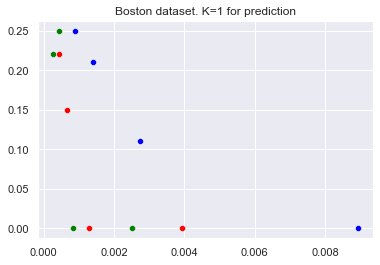

In [235]:
#bleu= K init 1
#sns.scatterplot(x=[1/9.0], y=[0.0], color='blue')
sns.scatterplot(x=[1/112.0], y=[0.0], color='blue')
sns.scatterplot(x=[1/365.0], y=[0.11], color='blue')
sns.scatterplot(x=[1/707.0], y=[0.21], color='blue')
sns.scatterplot(x=[1/1132.0], y=[0.25], color='blue')

#rouge= K init 2
#sns.scatterplot(x=[1/16.0], y=[0.0], color='red')
sns.scatterplot(x=[1/255.0], y=[0.0], color='red')
sns.scatterplot(x=[1/783.0], y=[0.0], color='red')
sns.scatterplot(x=[1/1485.0], y=[0.15], color='red')
sns.scatterplot(x=[1/2367.0], y=[0.22], color='red')

#vert= K init 3
#sns.scatterplot(x=[1/23.0], y=[0.0], color='green')
sns.scatterplot(x=[1/397.0], y=[0.0], color='green')
sns.scatterplot(x=[1/1195.0], y=[0.0], color='green')
sns.scatterplot(x=[1/2260.0], y=[0.25], color='green')
sns.scatterplot(x=[1/3638.0], y=[0.22], color='green')

plt.title('Boston dataset. K=1 for prediction')

In [244]:
pd.DataFrame([1, 2])

,0
0,1
1,2
